# Implementing Recurrent Neural Network - LSTM 

#### Installing essential libraries

In [3]:
from tensorflow.keras.layers import LSTM,BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading the data

In [5]:
df=pd.read_csv("C:/Users/riddh/OneDrive/Documents/Projects/Churn/Preprocessed_data.xls")
print(df.shape)

(7043, 37)


#### Splitting the data

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Dimensions of the split datasets

In [9]:
# Check the dimension of the sets
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (4930, 36)
y_train: (4930,)
X_test: (1057, 36)
y_test: (1057,)


#### Checking the number of counts for each class

In [11]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 3635, 1: 1295}


In [12]:
# Convert to NumPy arrays and reshape input to be 3D [samples, timesteps, features]
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = np.array(X_val).reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

In [13]:
# Check the dimensions of the sets
print('X_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_val:', np.shape(X_val))
print('y_val:', np.shape(y_val))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

X_train: (4930, 1, 36)
y_train: (4930,)
X_val: (1056, 1, 36)
y_val: (1056,)
X_test: (1057, 1, 36)
y_test: (1057,)


In [14]:
X_train_cleaned = np.array([[int(x) if isinstance(x, bool) else x for x in row] for row in X_train])

In [15]:
X_train_cleaned = np.array(X_train_cleaned, dtype=np.float32)

In [16]:
X_train = tf.convert_to_tensor(X_train_cleaned)

In [17]:
for i in range(5):  # Inspect the first 5 elements
    print(type(X_train[i]), X_train[i])


<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(
[[1.         0.         1.         1.         0.8807347  1.
  1.         0.19736524 0.656426   0.         1.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         1.         0.
  0.         1.         0.         0.         1.         0.
  0.17382641 0.57813716 0.7756936  0.17382641 0.03895304 0.19736524]], shape=(1, 36), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(
[[ 1.          0.          0.          0.         -1.2774446   1.
   1.          0.52473927 -0.9725857   0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          1.          0.
  -0.6703253   1.2424244   1.6318647  -0.6703253   0.2753513   0.52473927]], shape=(1, 36), dtype=float32)
<class 'tensorflow.python.framew

In [18]:
# Ensure consistent data types (convert to float32)
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Convert to TensorFlow tensors
X_train= tf.convert_to_tensor(X_train)
X_val= tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)

#### Model Designing

In [20]:
# Model Architecture
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='sigmoid', return_sequences=True,))
model.add(LSTM(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\riddh\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Fit Model
epochs = 500
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7332 - loss: 0.5938 - val_accuracy: 0.7367 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 2/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.5755 - val_accuracy: 0.7367 - val_loss: 0.5744 - learning_rate: 1.0000e-04
Epoch 3/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7339 - loss: 0.5766 - val_accuracy: 0.7367 - val_loss: 0.5716 - learning_rate: 1.0000e-04
Epoch 4/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.5715 - val_accuracy: 0.7367 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 5/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7405 - loss: 0.5638 - val_accuracy: 0.7367 - val_loss: 0.5637 - learning_rate: 1.0000e-04
Epoch 6/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7450 - loss: 0.5546 - val_accuracy: 0.7367 - val_loss: 0.5569 - learning_rate: 1.0000e-04
Epoch 7/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

#### Evaluate the Model

In [24]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8098 - loss: 0.4031  
Test Loss: 0.418583482503891
Test Accuracy: 0.8003784418106079


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print('Actual class:', y_test.iloc[0])

# Reshaping the input data to match the expected shape for prediction
# Ensure X_test[0] has the correct shape
sample = tf.reshape(X_test[0],(1, X_test.shape[1], X_test.shape[2]))

# Making a prediction for the first test sample
print('Class Probabilities:')
predictions = model.predict(sample)
print(predictions)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Actual class: 0
Class Probabilities:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
[[0.03974601]]
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[[674  87]
 [124 172]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       761
           1       0.66      0.58      0.62       296

    accuracy                           0.80      1057
   macro avg       0.75      0.73      0.74      1057
weighted avg       0.79      0.80      0.80      1057



<Axes: >

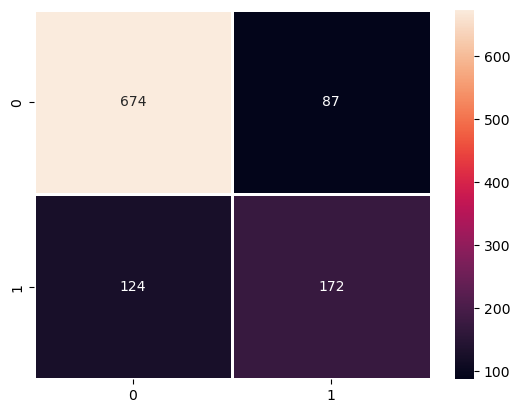

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm2=confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, linewidths=1, annot=True, fmt='g')

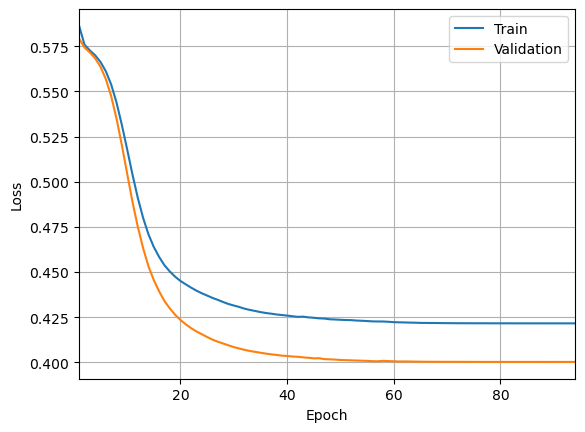

In [27]:
# Plot loss vs epochs
epoch_range = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.xlim((1, len(history.history['loss'])))
plt.legend(['Train', 'Validation'])
plt.show()

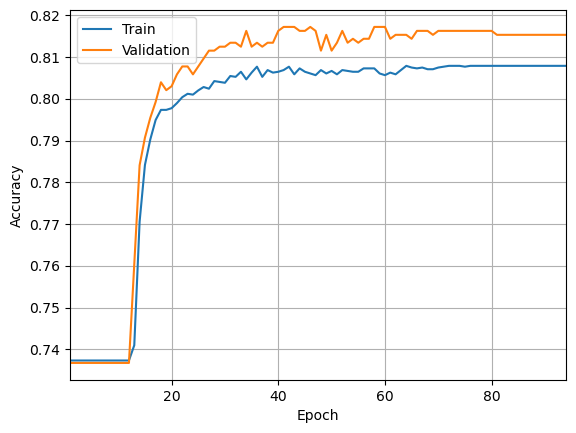

In [28]:
# Plot accuracy vs epochs
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.xlim((1, len(history.history['accuracy'])))
plt.legend(['Train', 'Validation'])
plt.show()

In [29]:
y_pred = model.predict(X_test)
print(y_test[:5])
print(y_pred[:5])

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23      0
3114    0
5525    0
437     0
3615    1
Name: Churn, dtype: int64
[[0.03974601]
 [0.37767416]
 [0.04135758]
 [0.06010637]
 [0.57829636]]


In [30]:
y_pred =[1 if y_pred[aa]>=0.5 else 0 for aa in range(len(y_pred)) ]
print(y_pred[:5])

[0, 0, 0, 0, 1]


In [31]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       761
           1       0.66      0.58      0.62       296

    accuracy                           0.80      1057
   macro avg       0.75      0.73      0.74      1057
weighted avg       0.79      0.80      0.80      1057

